In [7]:
import speech as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import IPython
%matplotlib inline

In [8]:
p = 10 #Order of the all pole filter
frame_size = 400 # Window size
iterations = 10 # Number of iterations of the Wiener Filter
alpha = 0.1 # Parameter of the sigma update

# Preparing the sample
x_clean, sr = sp.data.load('../samples/speech_male/arctic_a0004.wav')
SNR = 20
seed = 0
y = sp.data.add_white_noise(x_clean,SNR,seed)

# Get the list of frames for the STFT filtering
list_frames,y_padded,w_a,w_s = sp.data.frame_split(y,frame_size,with_overlap=False)
n_frames = len(list_frames)

# Create list of values per frame
s = np.zeros(y_padded.shape)
sigmas = np.zeros(len(list_frames))
is_speech = np.zeros(len(list_frames),dtype=bool)
filters = [None]*n_frames

vad = sp.vad.VAD(N=frame_size,fs = sr, N_fft = frame_size)
# Initialize relevant values at frame 0, 1
sigmas[0] = np.std(w_a*y_padded[list_frames[0]])
is_speech[0] = vad.decision_noise_level(w_a*y_padded[list_frames[0]])
filters[0] = np.zeros(int(frame_size//2+1))


for k in range(1,n_frames):
    idx = list_frames[k]
    frame = w_a*y_padded[idx]
    #1. Classify next frame
    is_speech[k] = vad.decision_noise_level(frame)
    
    #and (np.sum(frame**2) > frame_size*sigmas[k-1]**2)
    if(is_speech[k]): # If the frame is assumed to be speech
        # Update rule for sigma
        
        sigmas[k] = sigmas[k-1]
        # Through all pole model, compute a Wiener Filter and denoise the current frame
        denoised_frame, filters[k] = sp.process.denoise_frame(frame,p,sigmas[k]**2,iterations)
        
        loc_signal = w_s * denoised_frame
        s[idx] = s[idx] + loc_signal

    else: # If the frame is assumed to be noise
        # Evaluate the noise PSD
        sigma_loc = np.std(frame)
        sigmas[k] = (1-alpha)*sigmas[k-1]+alpha*sigma_loc
        filters[k] = filters[k-1]
        
        s[idx] = s[idx] + w_s*(np.fft.irfft(filters[k]*np.fft.rfft(frame)))

s = s/np.max(s)

        



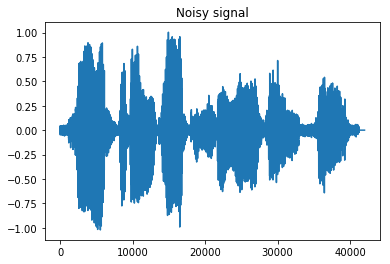

In [9]:
plt.plot(y_padded)
plt.title('Noisy signal')
IPython.display.Audio(y_padded,rate=sr)

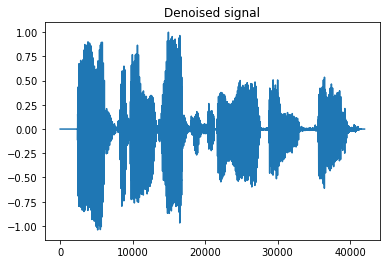

In [10]:
plt.plot(s)
plt.title('Denoised signal')
IPython.display.Audio(s,rate=sr)

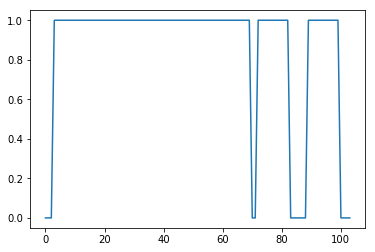

In [74]:
plt.plot(is_speech)

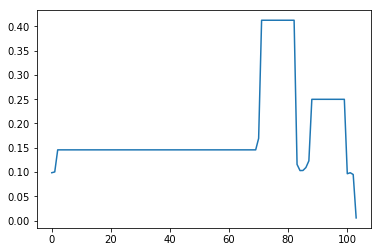

In [69]:
plt.plot(sigmas)

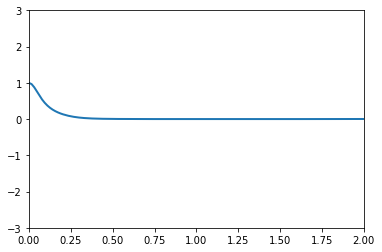

In [19]:
from matplotlib import animation
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-3, 3))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    omega = np.linspace(0,np.pi,int(frame_size//2) + 1)
    wf = filters[i]
    line.set_data(omega, wf)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames-1, interval=200, blit=True)
anim.save('filters.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.show()

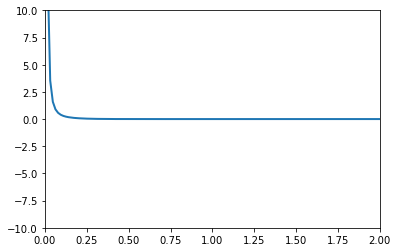

In [18]:
from matplotlib import animation
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-10, 10))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    omega = np.linspace(0,np.pi,int(frame_size//2) + 1)
    wf = speech_PSD[i]
    line.set_data(omega, wf)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames-1, interval=200, blit=True)
anim.save('speech_PSD.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.show()

In [5]:
p = 10 #Order of the all pole filter
frame_size = 400 # Window size
iterations = 10 # Number of iterations of the Wiener Filter
alpha = 0.1 # Parameter of the sigma update

# Preparing the sample
y_clean, sr = sp.data.load('../samples/speech_male/arctic_a0004.wav')
SNR = 20
seed = 0
y = sp.data.add_white_noise(y_clean,SNR,seed)

s = sp.process.denoise_with_vad(y,sr,frame_size,p,iterations,alpha)

        



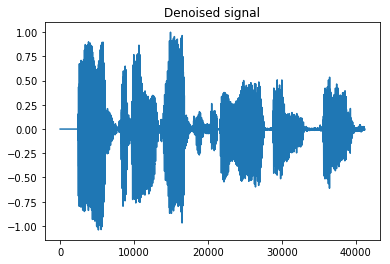

In [6]:
plt.plot(s)
plt.title('Denoised signal')
IPython.display.Audio(s,rate=sr)